# ELECTRICITY CONSUMPTION FORECAST

## 1. INTRODUCTION

### 1.1 Data

The data that we collected is about the electricity consumption from 1st of January, 2016 till the 1st of December, 2020. The data have data, hour and electricity consumption(MWh) as variables. This data can be reached from this [link](https://seffaflik.epias.com.tr/transparency/tuketim/gerceklesen-tuketim/gercek-zamanli-tuketim.xhtml)

### 1.2 Objective

In this assignment, we want to forecast the electirict consumptions of the next day's consumptions. In all tasks, we will use the data from 1st of November, 2020 till the end as test data. In this assignment, our performance metric will be mean absolute percentage error (MAPE).

## 2. TASKS

### 2.1 Packages and Funcitons

Throughout the assignment, we will use __numpy__, __pandas__, __datatable__, __matplotlib.pyplot__ and __CVXPY__ packages.

In [1]:
## Importing Packages
import numpy as np
import pandas as pd
import datatable as dt
from datatable import f, shift, update, join, by, mean, isna
from datatable.math import abs
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
import statsmodels.api as sm
import cvxpy as cp
import warnings

warnings.filterwarnings('error')
%matplotlib inline

When we are calculating the MAPE, we will use _calculate_mape_ function. When we want to get the long or wide format of the data, we will use _transform_long_ and _transform_wide_ functions.

In [2]:
def calculate_mape(dt):
    temp = dt
    temp[:, update(MAPE = mean(abs((f.pred - f.true) / f.true)) * 100)]
    return temp[0, "MAPE"]

def transform_long(df):
    long = df.copy()
    long[:,update(Lag_48 = shift(f["Consumption"], n = 48), Lag_168 = shift(f["Consumption"], n = 168))]
    # We can remove 7 days from data, because 7 << 1797.
    return long[169:long.nrows, ["Date", "Hour", "Lag_48", "Lag_168", "Consumption"]]

def transform_wide(df):
    df2 = df.to_pandas()
    lag_48 = pd.pivot_table(df2, index = 'Date', columns = 'Hour', values = 'Lag_48', aggfunc=np.mean, fill_value=0).reset_index()
    lag_168 = pd.pivot_table(df2, index = 'Date', columns = 'Hour', values = 'Lag_168', aggfunc=np.mean, fill_value=0).reset_index()
    df2["Date"] = df2["Date"].astype(str)
    lag_48["Date"] = lag_48["Date"].astype(str)
    lag_168["Date"] = lag_168["Date"].astype(str)
    df2 = dt.Frame(df2)
    lag_48 = dt.Frame(lag_48)
    lag_168 = dt.Frame(lag_168)
    lag_48.names = ['Date'] + ["Lag_day2_hour" + str(i) for i in range(0, 24)]
    lag_168.names = ['Date'] + ["Lag_day7_hour" + str(i) for i in range(0, 24)]
    lag_48.key = 'Date'
    lag_168.key = 'Date'
    temp = df2[:, :, join(lag_48)]
    wide = temp[:, :, join(lag_168)]
    wide = wide[:, f[:].remove([f.Lag_48, f.Lag_168])]
    return wide[:, [0, 1, range(3, 51), 2]]

### 2.2 Data Manupilation

Before starting tasks, we need to import the data and change the column names.

In [3]:
electricity = dt.fread("GercekZamanliTuketim.csv", columns = ['Date', 'Hour', 'Consumption'])
electricity.head()

,Date,Hour,Consumption
,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,01.01.2016,00:00,"26.277,24"
1,01.01.2016,01:00,"24.991,82"
2,01.01.2016,02:00,"23.532,61"
3,01.01.2016,03:00,"22.464,78"
4,01.01.2016,04:00,"22.002,91"
5,01.01.2016,05:00,"21.957,08"
6,01.01.2016,06:00,"22.203,54"
7,01.01.2016,07:00,"21.844,16"
8,01.01.2016,08:00,"23.094,73"


As we can see, the `Date` column is character type column. So need to change the type of the variable and check that do we have information for all days from 1st of January, 2016 till the 1st of December, 2020.

In [4]:
DateTime = electricity[:, f.Date + " " + f.Hour]
DateTime = DateTime.to_pandas()
DateTime = DateTime.apply(pd.to_datetime, format = "%d.%m.%Y %H:%M")

electricity[:, update(DateTime = DateTime.values)]
electricity[:, update(Date = DateTime.iloc[:,0].dt.date)]
electricity[:, update(Hour = DateTime.iloc[:,0].dt.hour)]

In [5]:
days = dt.Frame(Date = np.unique(electricity["Date"]))
days[0]

,Date
,▪▪▪▪▪▪▪▪
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05
5,2016-01-06
6,2016-01-07
7,2016-01-08
8,2016-01-09


In [6]:
lag_1_day = shift(days, n = 1)
print(sum([lag_1_day[i+1,0] == days[i,0] for i in range(0, days.nrows - 1)]))

1796


From the result, we can say that we have electricity consumption information for all days. Now, we need to check whether we have electricity consumption information for all hours.

In [7]:
hours = dt.Frame(Hour = np.unique(electricity[:,'Hour']))
print(hours)

   | Hour
-- + ----
 0 |    0
 1 |    1
 2 |    2
 3 |    3
 4 |    4
 5 |    5
 6 |    6
 7 |    7
 8 |    8
 9 |    9
10 |   10
11 |   11
12 |   12
13 |   13
14 |   14
15 |   15
16 |   16
17 |   17
18 |   18
19 |   19
20 |   20
21 |   21
22 |   22
23 |   23

[24 rows x 1 column]



In [8]:
lag_1_hour = shift(hours, n = 1)
print(sum([lag_1_hour[i+1,0] == hours[i,0] for i in range(0, hours.nrows - 1)]))

23


From the result, we can say that we have electricity consumption information for all days. Now, we need to check whether we have electricity consumption information for all hours of all days.

In [9]:
Date = electricity["Date"].to_pandas()
print(Date["Date"].value_counts().head())
print(sum(Date["Date"].value_counts() != 24))

2020-06-30    24
2019-11-14    24
2018-04-24    24
2017-11-23    24
2018-11-20    24
Name: Date, dtype: int64
0


We see that for all days we have 24 hours.

In [10]:
Hour = electricity["Hour"].to_pandas()
print(Hour["Hour"].value_counts())

4     1798
23    1797
22    1797
1     1797
2     1797
5     1797
6     1797
7     1797
8     1797
9     1797
10    1797
11    1797
12    1797
13    1797
14    1797
15    1797
16    1797
17    1797
18    1797
19    1797
20    1797
21    1797
0     1797
3     1796
Name: Hour, dtype: int64


As we can see from the table, there is a missing row for hour 3 and there is an addition for hour 4. As we have checked in the chunk before the previous one, we know that there 24 hours for all days. So, these errors are in the same date.

In [11]:
temp = electricity[:,dt.count(), by(["DateTime"])].to_pandas()
temp[temp.iloc[:,1].isin([2])]

,DateTime,count
2067,2016-03-27T04:00:00.000000000,2


As we can see, the problem is in the _2016-03-27_ date.

In [12]:
electricity[electricity["Date"].to_pandas()["Date"].astype(str).str.contains("2016-03-27"), :]

,Date,Hour,Consumption,DateTime
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪
0,2016-03-27,0,"27.424,42",2016-03-27T00:00:00.000000000
1,2016-03-27,1,"25.949,63",2016-03-27T01:00:00.000000000
2,2016-03-27,2,"0,00",2016-03-27T02:00:00.000000000
3,2016-03-27,4,"24.776,94",2016-03-27T04:00:00.000000000
4,2016-03-27,4,"24.776,94",2016-03-27T04:00:00.000000000
5,2016-03-27,5,"24.098,97",2016-03-27T05:00:00.000000000
6,2016-03-27,6,"23.267,43",2016-03-27T06:00:00.000000000
7,2016-03-27,7,"22.531,83",2016-03-27T07:00:00.000000000
8,2016-03-27,8,"23.398,59",2016-03-27T08:00:00.000000000


As we can see from the table above, we have some problem for this day. The error is due to the the daylight savings program Turkey used to apply in those years. To correct the error, we will change the hour from 4 to 3 and replace the `Consumption` column with zero.

In [13]:
idx = np.where(electricity["Date"].to_pandas()["Date"].astype(str).str.contains("2016-03-27"))[0]
datetime = "2016-03-27 03:00"
electricity[int(idx[3]), "Hour"] = 3
electricity[int(idx[3]), "Consumption"] = "0,00"

electricity[electricity["Date"].to_pandas()["Date"].astype(str).str.contains("2016-03-27"), :]

,Date,Hour,Consumption,DateTime
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪
0,2016-03-27,0,"27.424,42",2016-03-27T00:00:00.000000000
1,2016-03-27,1,"25.949,63",2016-03-27T01:00:00.000000000
2,2016-03-27,2,"0,00",2016-03-27T02:00:00.000000000
3,2016-03-27,3,"0,00",2016-03-27T04:00:00.000000000
4,2016-03-27,4,"24.776,94",2016-03-27T04:00:00.000000000
5,2016-03-27,5,"24.098,97",2016-03-27T05:00:00.000000000
6,2016-03-27,6,"23.267,43",2016-03-27T06:00:00.000000000
7,2016-03-27,7,"22.531,83",2016-03-27T07:00:00.000000000
8,2016-03-27,8,"23.398,59",2016-03-27T08:00:00.000000000


Now we finished the control related with any DateTime information. We need to check the type of the consumption.

In [14]:
type(electricity[0,"Consumption"])

str

It should a numeric variable. So, we need to convert it to character. But, as we saw from the `electricity.head()` command, comma is used as decimal separator and period is used as a thousand separator. So, we can use `replace` function to solve the issue.

In [15]:
Consumption = electricity[:, f.Consumption].to_pandas()
electricity["Consumption"] = Consumption["Consumption"].str.replace(".", "").str.replace(",", ".").astype(float).values

We need to check `Consumption` values whether there are 0 or not.

In [16]:
electricity[f.Consumption == 0, :]

,Date,Hour,Consumption,DateTime
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪
0,2016-03-27,2,0,2016-03-27T02:00:00.000000000
1,2016-03-27,3,0,2016-03-27T04:00:00.000000000


As we can see, there are two zero values in `Consumption` column. We can assign the average consumption of that hour for zero values.

In [17]:
electricity[f.Consumption == 0, update(Consumption = np.NaN)]
mean_2 = electricity[f.Hour == 2, mean(f.Consumption)]
mean_3 = electricity[f.Hour == 3, mean(f.Consumption)]

electricity[(isna(f.Consumption)) & (f.Hour == 2), update(Consumption = mean_2)]
electricity[(isna(f.Consumption)) & (f.Hour == 3), update(Consumption = mean_3)]
electricity[isna(f.Consumption),:]

,Date,Hour,Consumption,DateTime
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪


Now, we solved all problems in the data. To easily identify the train and test data, we can create a column.

In [18]:
idx2 = np.min(np.where(electricity["Date"].to_pandas()["Date"].astype(str).str.contains("2020-11-01"))[0])
electricity[:, update(Test = 0)]
electricity[int(idx2):, update(Test = 1)]
print(electricity.head())
print(electricity.tail())

   | Date  Hour  Consumption  DateTime                       Test
-- + ----  ----  -----------  -----------------------------  ----
 0 |          0      26277.2  2016-01-01T00:00:00.000000000     0
 1 |          1      24991.8  2016-01-01T01:00:00.000000000     0
 2 |          2      23532.6  2016-01-01T02:00:00.000000000     0
 3 |          3      22464.8  2016-01-01T03:00:00.000000000     0
 4 |          4      22002.9  2016-01-01T04:00:00.000000000     0
 5 |          5      21957.1  2016-01-01T05:00:00.000000000     0
 6 |          6      22203.5  2016-01-01T06:00:00.000000000     0
 7 |          7      21844.2  2016-01-01T07:00:00.000000000     0
 8 |          8      23094.7  2016-01-01T08:00:00.000000000     0
 9 |          9      25202.3  2016-01-01T09:00:00.000000000     0

[10 rows x 5 columns]

   | Date  Hour  Consumption  DateTime                       Test
-- + ----  ----  -----------  -----------------------------  ----
 0 |         14      41812.3  2020-12-01T14:00:00.00

We have reached final shape of the data. Throughout the assignment, we will use some formats of this data, which are in long and wide format. We can get these formatted data from the code below. Also, we removed first 186 rows from `electricity` data, because we removed the rows with NAs in `electricity_long` data

In [19]:
electricity_long = transform_long(electricity)
print(electricity_long.head())
electricity = electricity[169:electricity.nrows,:]
electricity_wide = transform_wide(electricity_long)
electricity_wide.head()

   | Date  Hour   Lag_48  Lag_168  Consumption
-- + ----  ----  -------  -------  -----------
 0 |          1  27614    24991.8      27112.4
 1 |          2  26579    23532.6      25975.3
 2 |          3  25719.2  22464.8      25315.5
 3 |          4  25864.6  22002.9      25128.2
 4 |          5  25918.6  21957.1      25356.2
 5 |          6  27091.9  22203.5      26338.7
 6 |          7  28533    21844.2      28086.4
 7 |          8  33203.3  23094.7      32702.2
 8 |          9  36257.2  25202.3      35788.2
 9 |         10  37212.9  27225        36843.2

[10 rows x 5 columns]



,Date,Hour,Lag_day2_hour0,Lag_day2_hour1,Lag_day2_hour2,Lag_day2_hour3,Lag_day2_hour4,Lag_day2_hour5,Lag_day2_hour6,Lag_day2_hour7,…,Lag_day7_hour20,Lag_day7_hour21,Lag_day7_hour22,Lag_day7_hour23,Consumption
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,2016-01-08,1,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,27112.4
1,2016-01-08,2,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,25975.3
2,2016-01-08,3,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,25315.5
3,2016-01-08,4,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,25128.2
4,2016-01-08,5,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,25356.2
5,2016-01-08,6,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,26338.7
6,2016-01-08,7,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,28086.4
7,2016-01-08,8,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,32702.2
8,2016-01-08,9,0,27614,26579,25719.2,25864.6,25918.6,27091.9,28533,…,30166.1,29461.3,29242.8,28069.1,35788.2


We are ready to accomplish the tasks.

### 2.3 Task 1

When we try to forecast the electricity consumption, we can use the consumption of values of 48 and 168 hours ago. To assign the value of these numbers would be our naïve approach. Our So, our MAPE values will be like these:

In [20]:
predict_lag168 = electricity[:, [f.Test, shift(f.Consumption, n = 168)]][f.Test == 1, :]
predict_lag48 = electricity[:, [f.Test, shift(f.Consumption, n = 48)]][f.Test == 1, :]

MAPE_lag168 = calculate_mape(dt.Frame(pred = predict_lag168["Consumption"], true = electricity[f.Test == 1, f.Consumption]))
MAPE_lag48 = calculate_mape(dt.Frame(pred = predict_lag48["Consumption"], true = electricity[f.Test == 1, f.Consumption]))

print(MAPE_lag168)
print(MAPE_lag48)

3.449188482612284
8.060314509077504


MAPE of lag 168 is 5.334224610142467 and MAPE of lag 48 is 8.630745447930549. Lag 168 naïve approach performs better than the lag 48 naïve approach. We can compare all other model with lag 168 naïve approach. With this approach, we see that weekly seasonality is more important than the two-day seasonality.

### 2.4 Task 2

Rather than using the consumption of seven days ago, we can create a model that uses the lag 168 and lag 48 values as input. Our model can be a linear regression model.

In [21]:
lin_reg = LinearRegression()
X_train = electricity_long[electricity[:, f.Test].to_pandas() == 0, [f.Lag_48, f.Lag_168]]
y_train = electricity_long[electricity[:, f.Test].to_pandas() == 0, f.Consumption]
X_test = electricity_long[electricity[:, f.Test].to_pandas() == 1, [f.Lag_48, f.Lag_168]]
y_test = electricity_long[electricity[:, f.Test].to_pandas() == 1, f.Consumption]
lin_reg.fit(X_train, y_train)

predict_lr = lin_reg.predict(X_test)
MAPE_lr = calculate_mape(dt.Frame(pred = predict_lr, true = y_test))
print(MAPE_lr)

4.228194547043501


When we compare the MAPE value of this model with lag 168 naïve approach, it is better to use the naïve approach than this linear regression. So, it means that out model is not good enough than just predicting the value of last week.

### 2.5 Task 3

In the linear regression model, we didn't divide the data respect to hours. So, our approach assumes that every hour will have the same coefficient. If this is not true, we need to model each hour separately.

In [22]:
model_lr_hourly = dt.Frame()

for i in range(0, 24):
    X_train = electricity_long[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 0), [f.Lag_48, f.Lag_168]]
    y_train = electricity_long[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 0), f.Consumption]
    X_test = electricity_long[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 1), [f.Lag_48, f.Lag_168]]
    y_test = electricity_long[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 1), f.Consumption]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    predict_lr = lin_reg.predict(X_test)
    MAPE_lr_hourly = calculate_mape(dt.Frame(pred = predict_lr, true = y_test))
    model_lr_hourly.rbind(dt.Frame({"Hour" : [i], "MAPE" : [MAPE_lr_hourly]}))

model_lr_hourly
model_lr_hourly[f.MAPE <= MAPE_lag168,:]

,Hour,MAPE
,▪▪▪▪,▪▪▪▪▪▪▪▪
0,0,3.26278
1,1,3.28309
2,2,3.42223
3,3,3.20699
4,4,3.18302
5,5,3.18745
6,6,3.14806
7,19,3.43379
8,20,3.16435


When we model all hours data individually, we see that there are 12 models that are better than the naïve approach. So, we still can say that naïve approach is a better approach, which means that weekly seasonality is more important than daily seasonality (or the importance of the weekly seaesonality is more than the importance of the hourly seasonality).

### 2.6 Task 4

Now, we have some linear regression models for all hour. We can go further in this step. We can create more features for a model and use a penalized regression model for creating a more generalized model. We can use all seven day ago hourly consumption values to predict the next day's consumption for every hour. So we will create 24 models with these features. We can create a Lasso Regression as a penalized regression. With adding L1 norm of the coefficients in the objective function, we can prevent the model from overfitting. In Lasso Regression, alpha is an important hyper parameter. So, we can use 10-fold cross validation to choose the best alpha value and predict *Consumption* values with these hourly models.

In [23]:
model_lasso_hourly = dt.Frame()

for i in range(0, 24):
    X_train = electricity_wide[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 0), "Lag_day2_hour0":"Lag_day7_hour23"]
    y_train = electricity_wide[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 0), f.Consumption]
    X_test = electricity_wide[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 1), "Lag_day2_hour0":"Lag_day7_hour23"]
    y_test = electricity_wide[(f.Hour == i) & (electricity[:, f.Test].to_pandas() == 1), f.Consumption]
    
    las_reg = LassoCV(cv=10, random_state=12345, max_iter=100000).fit(X_train, y_train.to_numpy().ravel())
    predict_lasso_hourly = las_reg.predict(X_test)
    MAPE_lasso_hourly = calculate_mape(dt.Frame(pred = predict_lasso_hourly, true = y_test))
    model_lasso_hourly.rbind(dt.Frame({"Hour" : [i], "MAPE" : [MAPE_lasso_hourly]}))


model_lasso_hourly
model_lasso_hourly[f.MAPE <= MAPE_lag168,:]

,Hour,MAPE
,▪▪▪▪,▪▪▪▪▪▪▪▪
0,0,1.4203
1,1,1.57439
2,2,1.63322
3,3,1.50176
4,4,1.49766
5,5,1.43566
6,6,1.69015
7,7,1.87627
8,8,2.5772


Now, we have better MAPE results than the naïve approach. So, we can conclude that using all hourly values of seven and two days ago in Lasso Regression is a better approach to forecast the next day's consumption than naïve approach. Also, we can understand the importance of using more features in a model. If additional variables do not contribute to score, they will have zero coefficients. So, there is nothing wrong with using more features in a model.

### 2.7 Task 5

For a better solution, we can try the fused regression, which also adds the differences of consecutive coefficients with a multiplier. We can make an implementation with the help of _cvxpy_ package. In this implementation, we are constructing models for every hour.

In [ ]:
beta = cp.Variable(48)
model_fused_hourly = dt.Frame()

for i in range(0, 24):
    X_train = electricity_wide[(electricity[:, f.Test].to_pandas() == 0), "Lag_day2_hour0":"Lag_day7_hour23"]
    y_train = electricity_wide[(electricity[:, f.Test].to_pandas() == 0), f.Consumption]
    X_test = electricity_wide[(electricity[:, f.Test].to_pandas() == 1), "Lag_day2_hour0":"Lag_day7_hour23"]
    y_test = electricity_wide[(electricity[:, f.Test].to_pandas() == 1), f.Consumption]
    
    obj = np.sum(np.square(y_train - np.dot(X_train, beta))) + 3.401877 * np.sum(np.square(beta)) + 3.401877 * np.abs(cp.atoms.pnorm(cp.atoms.affine.diff.diff(x = beta, k = 1), 1))
    prob = cp.Problem(cp.Minimize(obj))
    result = prob.solve()
    
    betas = beta.value
    predict_fused_hour = np.dot(X_test, betas)
    MAPE_fused_hour = calculate_mape(dt.Frame(pred = predict_fused_hour, true = y_test))
    model_fused_hourly = model_fused_hourly.rbind(dt.Frame({Hour = [i], MAPE = [MAPE_fused_hour]}))

model_fused_hourly

When we calculate MAPE values, we get the similar results with Lasso Regression. This approach could have better result, but we couldn't apply a grid search for lambda values. A further work could be to find a solution to come up with best lambda values. After this process we will not include the results of fused regression because of the same results.

### 2.8 Task 6

Now, at the end of the task, we can plot all MAPE values in a boxplot.

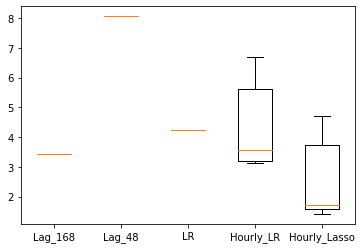

In [24]:
All_MAPE = [[MAPE_lag168], [MAPE_lag48], [MAPE_lr], model_lr_hourly["MAPE"].to_list()[0],  model_lasso_hourly["MAPE"].to_list()[0]]
Labels = ['Lag_168', 'Lag_48', 'LR', 'Hourly_LR', 'Hourly_Lasso']
_ = plt.boxplot(All_MAPE, labels = Labels)

When we look at the results of all MAPE values, we see that hourly lasso models are far better than the others. As we explained before, it is the expected result thanks to using more features and regularization that tries to overcome the overfitting problem. At the end of the task, we can come up with some information like below:

- In our data, weekly seasonality is more important than daily and hourly seasonality.
- To use all hourly consumption of a day is a better approach to create a model. In this type of situations, we need to consider the penalized regression to reduce the chance of overfitting.
- To use two-day and one-week before consumption information is a reliable process with respect to their MAPE values.

## REFERENCES
- [EPIAS](https://seffaflik.epias.com.tr/)
- [MAPE](https://www.statology.org/mape-r/)
- [DATATABLE](https://datatable.readthedocs.io/en/latest/)
- [CVXPY](https://www.cvxpy.org/)